In [172]:
# for better results take the image straight and include all the grid and not much of anthing else
#https://stackoverflow.com/questions/48954246/find-sudoku-grid-using-opencv-and-python

'''
NOTE:not easy to make it to work for every image because of the edges threshold arguments
optimization.

For now the approach will be to take an image forcing the segmentation and the submitting
the images of each square to a ML/OCR algorithm (see from section "# take a photo of a sudoku")
'''
import cv2
import numpy as np
import math

filter = False


file_path = 'sample00.jpg'
img = cv2.imread(file_path)

gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
#gray = cv2.equalizeHist(gray)
edges = cv2.Canny(gray,90,150,apertureSize = 3)
kernel = np.ones((3,3),np.uint8)
edges = cv2.dilate(edges,kernel,iterations = 1)
kernel = np.ones((5,5),np.uint8)
edges = cv2.erode(edges,kernel,iterations = 1)
cv2.imwrite('canny.jpg',edges)

lines = cv2.HoughLines(edges,1,np.pi/180,150)

if not lines.any():
    print('No lines were found')
    exit()

if filter:
    rho_threshold = 15
    theta_threshold = 0.1

    # how many lines are similar to a given one
    similar_lines = {i : [] for i in range(len(lines))}
    for i in range(len(lines)):
        for j in range(len(lines)):
            if i == j:
                continue

            rho_i,theta_i = lines[i][0]
            rho_j,theta_j = lines[j][0]
            if abs(rho_i - rho_j) < rho_threshold and abs(theta_i - theta_j) < theta_threshold:
                similar_lines[i].append(j)

    # ordering the INDECES of the lines by how many are similar to them
    indices = [i for i in range(len(lines))]
    indices.sort(key=lambda x : len(similar_lines[x]))

    # line flags is the base for the filtering
    line_flags = len(lines)*[True]
    for i in range(len(lines) - 1):
        if not line_flags[indices[i]]: # if we already disregarded the ith element in the ordered list then we don't care (we will not delete anything based on it and we will never reconsider using this line again)
            continue

        for j in range(i + 1, len(lines)): # we are only considering those elements that had less similar line
            if not line_flags[indices[j]]: # and only if we have not disregarded them already
                continue

            rho_i,theta_i = lines[indices[i]][0]
            rho_j,theta_j = lines[indices[j]][0]
            if abs(rho_i - rho_j) < rho_threshold and abs(theta_i - theta_j) < theta_threshold:
                line_flags[indices[j]] = False # if it is similar and have not been disregarded yet then drop it now

print('number of Hough lines:', len(lines))

filtered_lines = []

if filter:
    for i in range(len(lines)): # filtering
        if line_flags[i]:
            filtered_lines.append(lines[i])

    print('Number of filtered lines:', len(filtered_lines))
else:
    filtered_lines = lines

for line in filtered_lines:
    rho,theta = line[0]
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a*rho
    y0 = b*rho
    x1 = int(x0 + 1000*(-b))
    y1 = int(y0 + 1000*(a))
    x2 = int(x0 - 1000*(-b))
    y2 = int(y0 - 1000*(a))

    cv2.line(img,(x1,y1),(x2,y2),(0,0,255),2)

cv2.imwrite('hough.jpg',img)

number of Hough lines: 33


True

In [173]:
def lineF(p1, p2):
    A = (p1[1] - p2[1])
    B = (p2[0] - p1[0])
    C = (p1[0]*p2[1] - p2[0]*p1[1])
    return A, B, -C

def intersection(L1, L2):
    D  = L1[0] * L2[1] - L1[1] * L2[0]
    Dx = L1[2] * L2[1] - L1[1] * L2[2]
    Dy = L1[0] * L2[2] - L1[2] * L2[0]
    if D != 0:
        x = Dx / D
        y = Dy / D
        return x,y
    else:
        return False


def getLine(line):
    rho,theta = line[0]
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a*rho
    y0 = b*rho
    x1 = int(x0 + 1000*(-b))
    y1 = int(y0 + 1000*(a))
    x2 = int(x0 - 1000*(-b))
    y2 = int(y0 - 1000*(a))
    L1 = lineF([x1, y1], [x2, y2])
    return L1, x1, y1, x2, y2

def angle3pt(a, b, c):
    """Counterclockwise angle in degrees by turning from a to c around b
        Returns a float between 0.0 and 360.0"""
    ang = math.degrees(
        math.atan2(c[1]-b[1], c[0]-b[0]) - math.atan2(a[1]-b[1], a[0]-b[0]))
    return ang + 360 if ang < 0 else ang


# Remove lines that are almost overlapping

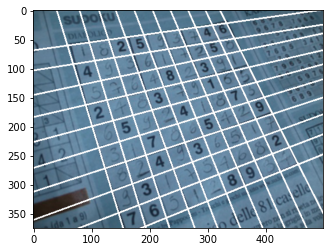

In [174]:
# trying to get whe 2 lines are almost the same
img = cv2.imread(file_path)
toleranceAng = 5
idxToRemove = []
for i in range(0,len(filtered_lines)-1):
    L1,x1,y1, x2, y2 = getLine(filtered_lines[i])
    for j in range(i+1,len(filtered_lines)):
        if not i == j:
            L2,x3,y3, x4, y4 = getLine(filtered_lines[j])
            R = intersection(L1, L2)
            if R:
                angIs = angle3pt((x1,y1), R, (x3,y3))
                if (angIs<=toleranceAng or angIs>=360-toleranceAng)\
                and R[0]>=0 and R[0]<=img.shape[1]\
                and R[1]>=0 and R[1]<=img.shape[0]:
                    idxToRemove.append(j)

filtered_lines = np.delete(filtered_lines, axis=0, obj=idxToRemove)

for i in range(0,len(filtered_lines)):
    L1,x1,y1, x2, y2 = getLine(filtered_lines[i])
    cv2.line(img,(x1,y1),(x2,y2),(255, 255, 255),2)

                    
plt.imshow(img)
plt.show()



## Get lines intersections

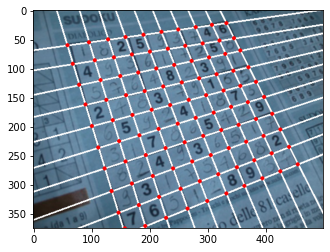

In [81]:
import cv2
import numpy as np
from __future__ import division 
from matplotlib import pyplot as plt

img = cv2.imread(file_path)
img2 = np.zeros(img.shape, dtype=np.uint8)
im_gray = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)

toleranceAng = 25
allR = []
for i in range(0,len(filtered_lines)-1): 
    L1,x1,y1, x2, y2 = getLine(filtered_lines[i])
    for j in range(i,len(filtered_lines)):
        L2,x3,y3, x4, y4 = getLine(filtered_lines[j])
        R = intersection(L1, L2)
        if R:
            angIs = angle3pt((x1,y1), R, (x3,y3))
            if (angIs >= 90-toleranceAng and angIs <= 90+toleranceAng) or\
            (angIs >= 270-toleranceAng and angIs <= 270+toleranceAng):
                R = [R[0],R[1]]
                # ensure that R is inside the figure
                if R[0]>img.shape[1]:
                    R[0] = img.shape[1]
                if R[1]>img.shape[0]:
                    R[1] = img.shape[0]
                R = (int(R[0]), int(R[1]))
                
                allR.append(R)
                
                cv2.line(img,(x1,y1),(x2,y2),(255, 255, 255),2)
                cv2.line(img,(x3,y3),(x4,y4),(255, 255, 255),2)
                

for i in allR:
    cv2.circle(img,(i[0],i[1]),2,(255, 0, 0),2)
                
                                             
# Displaying the image 
plt.imshow(img)
plt.show()

# Identify the squares

In [126]:
# first i try to sort the lines
# positive filtered_lines[i,0,0] are horizontal lines
# the max positive value is the lowest value
# the lowest negative value is the right most line

img = cv2.imread(file_path)
toleranceAng = 25
allH = []
allV = []
for i in range(0,len(filtered_lines)):
    L1,x1,y1, x2, y2 = getLine(filtered_lines[i])
    if filtered_lines[i,0,0]>=0:
        cv2.line(img,(x1,y1),(x2,y2),(255,255,255),2)
        allH.append(filtered_lines[i,0,0])
    else:
        cv2.line(img,(x1,y1),(x2,y2),(255,0,0),2)
        allV.append(filtered_lines[i,0,0])

allH.sort()#from top to bottom
allV.sort(reverse = True)#from left to right

# if I loop throught the lines now I should be able to get the squares
# I want to name the squares 1 to 81 going left to right, top to bottom

#loop by h
#get
counter = {0:[[0,0],[0,1],[1,0],[1,1]],
          1:[[0,1],[0,2],[1,1],[1,2]],
          2:[[0,2],[0,3],[1,2],[1,3]],
          3:[[0,3],[0,4],[1,3],[1,4]],
          4:[[0,4],[0,5],[1,4],[1,5]],
          5:[[0,5],[0,6],[1,5],[1,6]],
          6:[[0,6],[0,7],[1,6],[1,7]],
          7:[[0,7],[0,8],[1,7],[1,8]],
          8:[[0,8],[0,9],[1,8],[1,9]]}
idxR = 0
idxC = 0
img = cv2.imread(file_path)

for i in range(0,81):
    RR = []
    addToIdx = idxR//9
    for iii in range(0,4):
        thisIdx = counter[idxC][iii]
        slopeH = allH[counter[idxC][iii][0]+addToIdx]
        slopeV = allV[counter[idxC][iii][1]]
        for ii in range(0,len(filtered_lines)):
            #print('slopeH: {}, slopeV: {}, line: {}'.format(slopeH, slopeV, filtered_lines[ii,0,0]))
            if filtered_lines[ii,0,0] == slopeH:
                LH,x1,y1, x2, y2 = getLine(filtered_lines[ii])
            if filtered_lines[ii,0,0] == slopeV:
                LV,x1,y1, x2, y2 = getLine(filtered_lines[ii])
        R = intersection(LV, LH)
        RR.append([int(R[0]), int(R[1])])
    idxR = idxR+1
    if idxC>=8:
        idxC = 0
    else:
        idxC = idxC+1
    startRow = min([i[1] for i in RR])
    endRow = max([i[1] for i in RR])
    startCol = min([i[0] for i in RR])
    endCol = max([i[0] for i in RR])
    im = img[startRow:endRow,startCol:endCol,:]
    cv2.imwrite("./rois/ROI_{}.png".format(i), im)

[['0', '0', '0', '7', '0', '0', '0', '8', '0'], ['0', '9', '0', '0', '0', '3', '1', '0', '0'], ['0', '0', '6', '8', '0', '5', '0', '7', '0'], ['0', '2', '0', '6', '0', '0', '0', '4', '9'], ['0', '0', '0', '2', '0', '0', '0', '5', '0'], ['0', '0', '8', '0', '4', '0', '0', '0', '7'], ['0', '0', '0', '9', '0', '0', '0', '3', '0'], ['3', '7', '0', '0', '0', '0', '0', '0', '6'], ['1', '0', '5', '0', '0', '4', '0', '0', '0']]
image1.dat


True

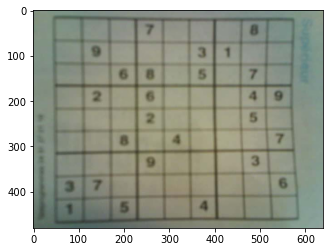

In [130]:
import os
labelsDataDir = 'D:\\repos\\sudokuSolver_py\\allImgsLabelledDB\\'
npyDataDir = 'D:\\repos\\sudokuSolver_py\\rawImg\\'

allNpys = []
for file in os.listdir(npyDataDir):
    if file.endswith(".npy"):
        allNpys.append(file)

allLabels = []
names = []
for file in os.listdir(labelsDataDir):
    if file.endswith(".dat"):
        with open(labelsDataDir+file) as f:
            allLabels.append([line.split()[0:9] for line in f])
            
            names.append(file)
print(allLabels[0][2:])
print(names[0])

from PIL import Image
# load the image
image = Image.open(npyDataDir +  names[0].replace('.dat', '.jpg'))
# convert image to numpy array
data = np.asarray(image)
plt.imshow(data)


cv2.imwrite('noted.jpg',data)


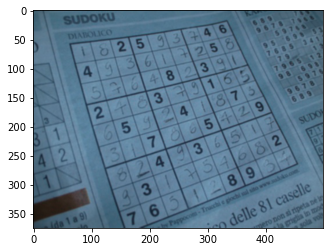

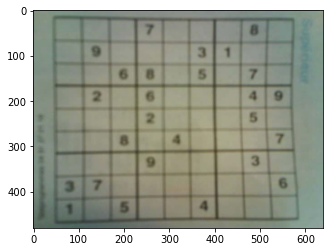

In [134]:
file_path = 'sample00.jpg'
file_path2 = 'noted.jpg'
img = cv2.imread(file_path)
img2 = cv2.imread(file_path2)
plt.imshow(img)
plt.show()
plt.imshow(img2)
plt.show()